# 📜 Previsões das cores de Cartas Magic - 2 Fase: StopWords; TF-IDF; Naive Bayes; Logistic Regression 🌊🧙‍♂️⚔️🌳

## Importar Bibliotecas

### Bibliotecas necessárias para a utilização do notebook

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import sys
import math
import sklearn
import re
from collections import defaultdict, Counter
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

nltk.download("stopwords")
nltk.download("punkt")



[nltk_data] Downloading package stopwords to C:\Users\David
[nltk_data]     Isaac\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\David
[nltk_data]     Isaac\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Regex

In [9]:
df = pd.read_csv("datasets/cleaner_data.csv")
print(df.size)
df.head()

88767


,Unnamed: 0,name,multiverse_id,color_identity,text,flavor,power
0,1,Ancestor's Chosen,NaN,['W'],First strike (This creature deals combat damag...,"""The will of all, by my hand done.""",4
1,2,Angel of Mercy,129465.0,['W'],Flying\r\nWhen Angel of Mercy enters the battl...,Every tear shed is a drop of immortality.,3
2,4,Angelic Blessing,129711.0,['W'],Target creature gets +3/+3 and gains flying un...,Only the warrior who can admit mortal weakness...,NaN
3,6,Angelic Chorus,129710.0,['W'],Whenever a creature enters the battlefield und...,The harmony of the glorious is a dirge to the ...,NaN
4,7,Angelic Wall,129671.0,['W'],Defender (This creature can't attack.)\r\nFlying,"""The Ancestor protects us in ways we can't beg...",0


### **Função: `clean_color`**

As cartas de *Magic: The Gathering* são divididas em várias categorias de **cores**. Algumas cartas possuem combinações de:
- **Duas cores** (ex.: Branco-Verde, Verde-Azul).  
- **Três ou mais cores**.

No entanto, a complexidade e diversidade dessas combinações de cores exigem:
1. **Maior poder de computação**.  
2. **Modelos mais robustos e avançados** para análise.


#### **Objetivo da Função**  
A função `clean_color` **filtra** as cartas, restringindo o foco para aquelas com **apenas um único tipo de cor**.  

Esta abordagem proporciona:  
- Uma análise **mais precisa e controlada**.  
- Maior **eficiência computacional**.  
- Redução da complexidade na interpretação dos resultados.



In [10]:
def clean_color(text):
    # as cores são branco(W), preto(B), azul(U), vermelho(R) ou verde(G)
    pattern = r"\['(W|B|U|R|G)'\]"
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    return None

df["color"] = df["color_identity"].apply(clean_color)
df.drop("color_identity", axis=1, inplace = True)

In [11]:
df["color"].value_counts()

color
W    2632
R    2575
B    2563
G    2475
U    2436
Name: count, dtype: int64

## Análise da coluna Text em cartas de *Magic: The Gathering* com Regex

Este código aplica **técnicas de *text mining*** para identificar e categorizar mecânicas específicas em cartas de *Magic: The Gathering*. A análise utiliza **expressões regulares** (regex) para pesquisar palavras-chave e padrões dentro do texto das cartas e, assim, atribuir valores **True/False** a diferentes colunas do DataFrame `df`.

Cada coluna representa uma mecânica ou habilidade específica do jogo. Abaixo está uma explicação detalhada das colunas e dos padrões utilizados:


### 1. **Anulações (`counterspell`)**  
Identifica cartas que anulam feitiços ou habilidades:  
- Padrões: `counter target`, `counter all`  
- Exclui a mecânica **Ward**, que é mais transversal.  


### 2. **Exílio (`exile`)**  
Procura cartas que exilam permanentes do tabuleiro:  
- Padrões: `exile target`, `exile each`, etc.  
- Ignora cartas que exilam do **topo do deck**.



### 3. **Luta (`fight`)**  
Identifica cartas que contêm a palavra `fights`, uma mecânica característica do **verde**.



### 4. **Mill (`mill`)**  
Procura a palavra-chave `mill`.  
> *Nota*: Cartas antigas referem-se a esta mecânica como "descartar cartas do topo do baralho" (*a adicionar futuramente*).



### 5. **Scry (`scry`)**  
Identifica cartas que contêm a palavra `scry`.



### 6. **Tap e Untap (`tap` e `untap`)**  
- **Tap**: Captura cartas que giram permanentes com padrões como `tap target`.  
- **Untap**: Procura cartas que desviram permanentes com padrões como `untap each`.



### 7. **Double Strike e First Strike (`double_strike` e `first_strike`)**  
Identifica cartas com estas habilidades de combate.



### 8. **Flash (`flash`)**  
Captura cartas com a habilidade `flash`:  
- Exclui referências à mecânica **flashback**.


### 9. **Flying (`flying`)**  
Identifica cartas que contêm a habilidade `flying`.


### 10. **Haste (`haste`)**  
Procura cartas com a palavra `haste`.


### 11. **Hexproof (`hexproof`)**  
Detecta cartas com a habilidade **Hexproof**.


### 12. **Indestrutível (`indestructible`)**  
Identifica cartas com a palavra `indestructible`, ignorando textos que indiquem **perda** da habilidade.


### 13. **Sacrificar (`sacrifice`)**  
Procura cartas com a mecânica de **sacrificar** permanentes.


### 14. **Lifelink (`lifelink`)**  
Identifica cartas que contêm a palavra `lifelink`.


### 15. **Menace (`menace`)**  
Procura cartas com a habilidade `menace`.


### 16. **Proteção (`protection`)**  
Captura cartas com padrões como `protection from`.


### 17. **Prowess (`prowess`)**  
Identifica cartas com a palavra `prowess`.


### 18. **Reach (`reach`)**  
Procura cartas com a habilidade `reach`:  
- Exclui textos explicativos sobre **flying**.



### 19. **Trample (`trample`)**  
Detecta cartas com a habilidade **trample**.


### 20. **Vigilância (`vigilance`)**  
Identifica cartas com a palavra `vigilance`.


### 21. **Comprar e Descarta (`draw` e `discard`)**  
- **Draw**: Captura cartas que permitem **comprar** cartas.  
- **Discard**: Procura cartas com a palavra `discard`.



### 22. **Dano e Prevenção de Dano (`damage` e `damage_prevention`)**  
- **Damage**: Identifica cartas que causam dano (`deals X damage`).  
- **Damage Prevention**: Procura cartas com o texto `prevent`.


### 23. **Ganho e Perda de Vida (`life_gain` e `life_loss`)**  
- **Life Gain**: Procura cartas que permitem **ganhar vida**.  
- **Life Loss**: Captura cartas que causam **perda de vida** com valores fixos ou relativos.


### 24. **Criação de Tokens (`tokens`)**  
Identifica cartas que geram fichas com o padrão `create`.



### 25. **Destruição e Recursão (`destroy` e `recursion`)**  
- **Destroy**: Procura cartas que destroem permanentes.  
  - Exclui textos sobre **indestrutibilidade**.  
- **Recursion**: Captura cartas que devolvem permanentes do **cemitério** para a mão ou campo de batalha.



### 26. **Devolução (`return`)**  
Procura cartas que devolvem permanentes à **mão** ou **biblioteca** do jogador:  
- Exclui efeitos de **recursão** do cemitério.



In [12]:
df["counterspell"] = (df.text.str.contains(r"[Cc]ounter\s(?:it|target|all)") & # anulações
         (df.text.str.contains(r"[wW]ard(?:\s{|—])") == False)) # Ward é uma maneira de anulação/proteção mais transversal às cores e é ignorada


df["exile"] = (df.text.str.contains(r"[eE]xile\s(?:target|each|all|the|up\sto)") & # exilar algo do tablueiro
        (df.text.str.contains(r"the\stop") == False)) # Algumas cartas "compram" cartas exilando-as do topo do deck, isso nào conta como exilar algo do tabuleiro

df["fight"] = (df.text.str.contains(r"[Ff]ights")) # Criaturas lutarem é uma mecânica característica do verde


df["mill"] = (df.text.str.contains(r"[mM]ill")) # TODO: mill é uma palavra chave recente, antes era referida por descartar a carta do >TOPO DO BATALHO<, bom adicionar este texto também


df["scry"] = (df.text.str.contains(r"[sS]cry"))


df["tap"] = (df.text.str.contains(r"(?:\st|T)ap\s(?:it|target|each|all|or\suntap)")) # cartas que viram outras 


df["untap"] = (df.text.str.contains(r"[uU]ntap\s(?:it|target|each|all)")) # find untappers

"""
df.loc[df.text.str.contains("[dD]eathtouch") | # find creatures that have deathtouch
        df.text.str.contains("deals combat damage to a creature, destroy that creature", regex = False)] # or that have "derptouch"
"""

df["double_strike"] = (df.text.str.contains(r"[dD]ouble\sstrike"))


df["first_strike"] = (df.text.str.contains(r"[fF]irst\sstrike"))


df["flash"] = (df.text.str.contains(r"(?:f|\nF|^F)lash") & # some engineering to avoid incorrectly grabbing cards with Flash in the name
        (df.text.str.contains(r"[fF]lashback") == False)) # dont' want to capture flashback


df["flying"] = (df.text.str.contains(r"[fF]lying"))


df["haste"] = (df.text.str.contains(r"[hH]aste"))


df["hexproof"] = (df.text.str.contains(r"[hH]exproof"))


df["indestructible"] = (df.text.str.contains(r"[iI]ndestructible") &
                         (df.text.str.contains(r"loses\sindestructible") == False))


df["sacrifice"] = (df.text.str.contains(r"[sS]acrifice"))


df["life"] = (df.text.str.contains(r"[lL]ife"))


df["gain"] = (df.text.str.contains(r"[gG]ain"))


df["lifelink"] = (df.text.str.contains(r"[lL]ifelink"))


df["menace"] = (df.text.str.contains(r"[mM]enace"))


df["protection"] = (df.text.str.contains(r"[pP]rotection\sfrom"))


df["prowess"] = (df.text.str.contains(r"[pP]rowess"))

df["spell"] = (df.text.str.contains(r"[sS]pell"))


df["reach"] = (df.text.str.contains(r"(?:\sr|\nR|^R)each") &
        (df.text.str.contains(r"can't be blocked except by creatures with flying or reach", regex = False) == False)) # don't want flying reminder text


df["trample"] = (df.text.str.contains(r"[tT]rample"))


df["vigilance"] = (df.text.str.contains(r"[vV]igilance"))


df["draw"] = (df.text.str.contains(r"(?:\sd|\nD|^D)raw"))

df["discard"] = (df.text.str.contains(r"[dD]iscard"))

df["deal"] = (df.text.str.contains(r"[dD]eal"))

df["land"] = (df.text.str.contains(r"[lL]and"))

df["damage"] = (df.text.str.contains(r"deals\s\d\sdamage"))


df["damage_prevention"] = (df.text.str.contains(r"[pP]revent\s"))


df["life_gain"] = (df.text.str.contains(r"gain(?:\s|s\s)\d+\slife"))


df["life_loss"] = (df.text.str.contains(r"loses") & 
                   df.text.str.contains(r"(?:their|\d+)\slife")) # capture both fixed and rational values


df["tokens"] = (df.text.str.contains(r"[cC]reate"))


df["destroy"] = (df.text.str.contains(r"[dD]estroy") &
                  (df.text.str.contains(r"don't\sdestroy\sit.") == False)) # reject indestructible's reminder text


df["return"] = (df.text.str.contains(r"[rR]eturn") &
        df.text.str.contains(r"owner's\s(?:hand|library)") & # capture hand or library bounce effects
        (df.text.str.contains(r"graveyard\sto") == False)) # exclude grave recursion


df["recursion"] = (df.text.str.contains(r"\sput|return") &
        df.text.str.contains(r"graveyard")&
        df.text.str.contains(r"hand|battlefield"))

In [13]:
df.head()

,Unnamed: 0,name,multiverse_id,text,flavor,power,color,counterspell,exile,fight,...,deal,land,damage,damage_prevention,life_gain,life_loss,tokens,destroy,return,recursion
0,1,Ancestor's Chosen,NaN,First strike (This creature deals combat damag...,"""The will of all, by my hand done.""",4,W,False,False,False,...,True,False,False,False,True,False,False,False,False,False
1,2,Angel of Mercy,129465.0,Flying\r\nWhen Angel of Mercy enters the battl...,Every tear shed is a drop of immortality.,3,W,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,4,Angelic Blessing,129711.0,Target creature gets +3/+3 and gains flying un...,Only the warrior who can admit mortal weakness...,NaN,W,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,6,Angelic Chorus,129710.0,Whenever a creature enters the battlefield und...,The harmony of the glorious is a dirge to the ...,NaN,W,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,7,Angelic Wall,129671.0,Defender (This creature can't attack.)\r\nFlying,"""The Ancestor protects us in ways we can't beg...",0,W,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## STOP WORDS

### **Função: `remove_reminder_text`**

Esta função é utilizada para **limpar o texto de regras** de cartas de *Magic: The Gathering*, removendo informações que estão entre parênteses. Essas informações, conhecidas como **texto de lembrete**, podem referir mecânicas diferentes e criar confusões na análise.

#### **Objetivo**  
- **Remover textos entre parênteses**: Evitar que lembretes de regras causem ruído na análise.
- **Lidar com valores nulos**: Substituir valores nulos por uma string vazia.
- **Uniformizar texto**: Converter tudo para **minúsculas** e remover espaços extras.


In [14]:
def remove_reminder_text_and_mana_costs(text):
    if not isinstance(text, str):
        return ""  # alguns valores nulos, cartas sem texto de regra (costumam não ser muito jogadas mas existem)
    # Remove tudo o que está entre parentesis
    # São lembretes de regra para facilitar o jogo, mas que podem referir outras mecanicas diferentes e confundir 
    text_no_parentheses = re.sub(r'\(.*?\)', '', text)
    # Remove o custo de mana de algumas habilidades ativáveis nas cartas
    text_no_costs = re.sub(r"\{.*?\}",'',text_no_parentheses)
    # Devolve o texto em lower case
    return text_no_costs.strip().lower()

df["text"] = df["text"].apply(remove_reminder_text_and_mana_costs)

df["text"]

0        first strike \r\nwhen ancestor's chosen enters...
1        flying\r\nwhen angel of mercy enters the battl...
2        target creature gets +3/+3 and gains flying un...
3        whenever a creature enters the battlefield und...
4                                      defender \r\nflying
                               ...                        
12676    trample\r\nlandfall — whenever a land enters t...
12677    when turntimber ascetic enters the battlefield...
12678              put a +1/+1 counter on target creature.
12679    veteran adventurer is also a cleric, rogue, wa...
12680    the first kicked spell you cast each turn cost...
Name: text, Length: 12681, dtype: object

### **Função: `remove_punctuation`**

#### **Objetivo**  
Remover a **pontuação** de uma lista de frases, preservando apenas os caracteres alfabéticos e espaços.


In [15]:
def remove_punctuation(sentences):
    sentences_without_punctuation = [
        re.sub(r"[^a-zA-Zà-úÀ-Úâ-ûÂ-ÛãõÃÕáéíóúÁÉÍÓÚçÇüÜ ]+", "", sentence) for sentence in sentences
    ]
    return sentences_without_punctuation
    
df["flavor"] = df["flavor"].apply(remove_punctuation)
df["text"] = df["text"].apply(remove_punctuation)

### **Função: `remove_non_letter_words`**

#### **Objetivo**  
Remover palavras do texto que contenham **números**, **caracteres especiais** ou **letras repetidas** excessivamente (como em onomatopéias), deixando apenas palavras compostas por letras únicas e válidas.


In [16]:
#Ver se as colunas contêm strings em vez de listas
df["text"] = df["text"].apply(lambda x: "".join(x) if isinstance(x, list) else x)
df["flavor"] = df["flavor"].apply(lambda x: "".join(x) if isinstance(x, list) else x)

In [17]:
def remove_non_letter_words(text):
    if isinstance(text, list):  # Verifica se o input é uma lista
        text = "".join(text)  # Converte a lista de caracteres para uma string
    words = text.split()  # Agora pode usar split
    clean_words = [word for word in words if re.search(r"[a-zA-Z]", word) and not re.search(r"(.)\1{2,}", word)]
    return " ".join(clean_words)

df["flavor"] = df["flavor"].apply(remove_non_letter_words)
df["text"] = df["text"].apply(remove_non_letter_words)

In [18]:
'''
print("\nColunas e valores únicos:")
for coluna in df.columns:
    print(f"\nColuna: {coluna}")
    print(df[coluna].unique())
'''

'\nprint("\nColunas e valores únicos:")\nfor coluna in df.columns:\n    print(f"\nColuna: {coluna}")\n    print(df[coluna].unique())\n'

In [19]:
#print(df.dtypes)

**Objetivo**  
Preencher valores nulos na coluna `text` com uma string vazia e criar uma nova coluna `all_Text` que combina os textos das colunas `text` e `flavor`.


In [20]:
df["text"] = df["text"].fillna("")
df["all_Text"] = df["text"] + " " + df["flavor"]
print(df[["text", "flavor", "all_Text"]])

                                                    text  \
0      first strike when ancestors chosen enters the ...   
1      flyingwhen angel of mercy enters the battlefie...   
2      target creature gets and gains flying until en...   
3      whenever a creature enters the battlefield und...   
4                                        defender flying   
...                                                  ...   
12676  tramplelandfall whenever a land enters the bat...   
12677  when turntimber ascetic enters the battlefield...   
12678                   put a counter on target creature   
12679  veteran adventurer is also a cleric rogue warr...   
12680  the first kicked spell you cast each turn cost...   

                                                  flavor  \
0                        The will of all by my hand done   
1               Every tear shed is a drop of immortality   
2      Only the warrior who can admit mortal weakness...   
3      The harmony of the glorious is a

### **Função: Pré-processamento de Texto para Previsão de Cores**

#### **Objetivo**  
A função `preprocess` é responsável por realizar o pré-processamento de texto, tornando-o mais adequado para o modelo de previsão de cores. O pré-processamento envolve a eliminação de stop words.


In [21]:
df["flavor"] = df["flavor"].astype(str)  #meter os valores em str (algum poderia estar em numero, float, etc) - tendo em conta que flavor = object

#stop words tendo em conta a biblioteca NLTK (Natural Language Toolkit) English
stop_words = set(stopwords.words("english")) 


In [22]:
lemmatizer = WordNetLemmatizer()
def preprocess(text, stop_words): #fazemos o processamento de cada palavra de forma a ficar mais "pronta" para ser utilizada no processo de prever as cores
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]#retirada de todas as stopwords
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    return lemmatized_tokens

#ONDE MUDAMOS O TIPO DE PREVISAO E A COLUNA ESCOLHIDA PARA PROCESSAR TEXTOS

#df["processed_flavor"] = df["flavor"].apply(lambda x: preprocess(x, stop_words)) #um lambda para utilizar a função preprocess em cada frase da coluna "processed_flavor"
df["processed_flavor"] = df["all_Text"].apply(lambda x: preprocess(x, stop_words)) #um lambda para utilizar a função preprocess em cada frase da coluna "processed_flavor"
#df["processed_flavor"] = df["text"].apply(lambda x: preprocess(x, stop_words)) #um lambda para utilizar a função preprocess em cada frase da coluna "processed_flavor"

#print(df["processed_flavor"])

## TF IDF 

## Objetivo do Uso de TF-IDF no Projeto

O objetivo do uso do **TF-IDF (Term Frequency-Inverse Document Frequency)** é criar uma representação numérica para o texto das cartas do jogo **Magic: The Gathering**, com o intuito de prever a cor associada a cada carta com base na descrição textual. 

Esta abordagem permite:

- **Capturar a importância de cada palavra** no contexto da descrição textual da carta, considerando a frequência relativa da palavra no conjunto total de cartas.
- **Reduzir o peso de palavras muito comuns** (e.g., palavras que aparecem em todas as cartas), enquanto destaca palavras mais relevantes para descrever cada carta de forma única.
  
### Passos tomados

1. **Pré-processamento do Texto**: 
   - Todas as descrições das cartas foram submetidas às seguintes etapas:
     - Remoção de stopwords (palavras muito comuns e irrelevantes).
     - Tokenização (separação do texto em palavras).
     - Lemmatização (redução das palavras às suas formas básicas).
   
2. **Armazenamento**:
   - As descrições processadas foram armazenadas na coluna `processed_flavor`, contendo listas de palavras que passaram pelo pré-processamento.

3. **Aplicação do TF-IDF**:
   - O TF-IDF foi aplicado às palavras da coluna `processed_flavor`.
   - Cada carta foi representada por um vetor numérico, onde cada posição corresponde ao peso TF-IDF de uma palavra.


A coluna `processed_flavor` contém listas de palavras (tokens) que foram extraídas após a remoção de stop words. Para realizar a transformação de frequência de termos (TF-IDF) ou outras análises de texto, é necessário reagregar essas palavras de volta em uma string única.


In [23]:
df["processed_flavor"] = df["processed_flavor"].apply(lambda x: " ".join(x)) #como o processed flavor vinha numa lista 
#(por culpa do processamento de retirada de stop words), houve a necessidade de voltar a juntar as palavras numa frase para se processeder a realização do TF IDF

De seguida decidimos preparar os dados para a previsão das cores, criando os conjuntos de treino e teste, e usando a transformação TF-IDF para representar o texto de forma numérica. O foco é avaliar a capacidade do modelo de fazer previsões sobre dados que nunca foram vistos antes, ou seja, novas frases de cartas "inexistentes"

In [24]:
X = df #todos os dados, mas o que nos queremos será o processed_Flavor
y = df["color"] #cor

df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#inicialmente, para vermos como as previsões estão a funcionar, houve a necessidade de fazer tambem a tabela do TF IDF só com o dataset de treino de forma a
#ver realmente como se comporta a previsão do tf idf com novos dados
#se o tfidf tivesse utilizado os dados todos das cartas, nao tinhamos dados para testar as previsões
#posteriormente decidimos acrescentar o resto das cartas para ter o dataset de previsão final utilizado para prever cartas novas e as suas cores
#quando utilizamos o data set todo, e pegamos em cartas ja existentes, a previsão chega a 0.70% o que é natural porque a frase ja existe dentro da tabela, o que nos queremos
#é ver como se comporta com frases que a mesma nunca teve interação mas que ja teve interação com palavras de outras frases

## Agrupamento de Cores e Aplicação do TF-IDF

De forma a termos os documentos representados pelas cores, foi necessário agrupar todas as linhas de uma mesma cor em um único texto. Por exemplo, as 300 linhas originalmente associadas à cor azul foram combinadas em uma única linha, contendo todas as palavras associadas a essa cor.


In [25]:
#de forma a termos os documentos como as cores, tivemos de juntar todas as cores em uma cor unica, as, imaginemos, 300 linhas com cor azul, passa a ser 1 linha de cor azul com as varias palavras que essa cor conteve
df_grouped = df_train.groupby("color")["processed_flavor"].apply(lambda x: " ".join(x)).reset_index()

#Iniciamos o TfidfVectorizer e ajustamos consoante os textos agrupados por cor
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(df_grouped["processed_flavor"])

#Pegar na matriz do TFIDF e passar para dataframe, de forma a tornar mais facil utilizar e vizualizar os dados
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=df_grouped["color"]
)

De seguida, para termos uma ideia das palavras que tem mais "importancia" e a sua cor, decidimos fazer um codigo que nos permitisse ver o top 20 das mesmas. 

In [26]:
#queria meter uma tabela de 1D onde so mostra o valor de tfidf com maior valor de uma cor e certa palavra
tfidf_data = tfidf_df.stack().reset_index()
tfidf_data.columns = ["color", "word", "tfidf"]
#ordenar os dados para ver o Top 20 
top_tfidf_all = tfidf_data.sort_values(by="tfidf", ascending=False).head(20)
print(top_tfidf_all)

       color      word     tfidf
85613      W  creature  0.606746
24131      G  creature  0.592940
3637       B  creature  0.572085
44625      R  creature  0.496761
63842      U      card  0.430140
65119      U  creature  0.413124
78994      U    target  0.407452
58500      R    target  0.375678
2360       B      card  0.355982
44896      R    damage  0.345607
99488      W    target  0.338763
17512      B    target  0.338143
45044      R      deal  0.311929
85324      W   control  0.296473
59587      R      turn  0.280656
38006      G    target  0.270255
23842      G   control  0.263582
22854      G      card  0.255479
100575     W      turn  0.253293
39093      G      turn  0.244039


In [27]:
#agora queriamos ver os valores dessas mesmas palavras mas para todas as cores

#As 20 palavras mais "importantes"
top_20_words = top_tfidf_all["word"].unique()
filtered_tfidf = tfidf_df[top_20_words]
top_20_tfidf = filtered_tfidf.loc[df["color"].unique()]
print(top_20_tfidf)

       creature      card    target    damage      deal   control      turn
color                                                                      
W      0.606746  0.139779  0.338763  0.120192  0.051638  0.296473  0.253293
U      0.413124  0.430140  0.407452  0.035451  0.031670  0.235868  0.154567
B      0.572085  0.355982  0.338143  0.066088  0.051492  0.143934  0.198263
R      0.496761  0.145139  0.375678  0.345607  0.311929  0.199666  0.280656
G      0.592940  0.255479  0.270255  0.066253  0.040991  0.263582  0.244039


### Propósito da Filtragem de Palavras

O objetivo deste codigo/função é de identificar e remover palavras que não contribuem significativamente para distinguir certas cores especificas. A relevância de cada palavra é avaliada com base em sua importância relativa para cada cor, utilizando os valores de TF IDF. Se uma palavra for relevante em todas as cores, tratamos ela como uma StopWord.

#### Objetivo Principal

O nosso principal propósito é de melhorar a eficácia do nosso modelo ao eliminar StopWords identificadas pelo TD IDF. Estas palavras são considerados StopWords por aparecerem em todas as cores

#### Lógica da Filtragem

1. **Avaliação da Relevância das Palavras:**  
   Para cada palavra no conjunto de dados TF-IDF:
   - Calcula-se o valor máximo de importância (TF-IDF) associado à palavra.
   - Define-se um intervalo proporcional ao valor máximo, consideramos 1/3 do máximo.
   - Verifica-se se as importâncias da palavra nas outras cores (excluindo a cor com o valor máximo) estão dentro desse intervalo.

2. **Remoção de Palavras StopWord:**  
   - Se a importância da palavra é próxima em múltiplas cores, ela é considerada StopWord e adicionada à lista de palavras a serem removidas.  
   - Palavras StopWord não ajudam a distinguir as cores, podendo prejudicar a precisão do modelo ao introduzir ruído.

3. **Aplicação da Filtragem:**  
   - As palavras StopWord são removidas tanto do conjunto de dados TF-IDF quanto do texto processado no conjunto de treino



In [28]:
#palavras a serem retiradas, a ideia é ver se existe palavras que tem a mesma importancia, ou parecida em todas as cores 
words_to_remove = []

for word in tfidf_df.columns:
    max_value = tfidf_df[word].max()
    intervalo = max_value / 4
    #calculamos o intervalor entre o max_value e os valores perto do mesmo, se nas outras cores a 
    #importancia tiver perto logo a palavra não é importante so para uma cor mas para varias, podendo nao ajudar na previsao das cores no futuro
    if all(tfidf_df[word].drop(index=tfidf_df[word].idxmax()) > max_value - intervalo): #excluimos o max_value da palavra atual durante a comparação
        words_to_remove.append(word)

In [29]:
def remove_words(text, words_to_remove):
    # Transformar o texto em uma lista de palavras
    words = text.split()
    # Converter a lista de palavras a remover para minúsculas
    words_to_remove_set = set(word.lower() for word in words_to_remove)
    
    # Criar uma lista para armazenar as palavras filtradas
    filtered_words = []
    
    # Iterar sobre as palavras do texto
    for word in words:
        # Adicionar a palavra na lista de filtradas se não estiver na lista 'words_to_remove'
        if word.lower() not in words_to_remove_set:
            filtered_words.append(word)
    
    # Juntar as palavras restantes em uma frase
    return " ".join(filtered_words)


words_to_remove.extend([
    "card", "target", "end", "turn", "battlefield", "player", "control",
    "damage", "creature", "graveyard", "opponent", "one", "never", "even",
    "every", "see", "the", "get"
])
#stopwords que observamos durante a visualização dos dados que aparecia em todas as cores em grandes quantidades

    
#para removermos as palavras anteriores tambem no proprio df
df_train["processed_flavor"] = df_train["processed_flavor"].apply(lambda x: remove_words(x, words_to_remove))
df_test["processed_flavor"] = df_test["processed_flavor"].apply(lambda x: remove_words(x, words_to_remove))

columns_to_remove = [word for word in words_to_remove if word in tfidf_df.columns]
# Remover as colunas identificadas
filtered_tfidf_df = tfidf_df.drop(columns=columns_to_remove)

print("Palavras removidas:", words_to_remove)

Palavras removidas: ['bottle', 'callapheia', 'candle', 'come', 'contained', 'creaturewhenever', 'diamond', 'far', 'helping', 'keeping', 'lead', 'list', 'mean', 'nearby', 'option', 'send', 'spin', 'stickered', 'think', 'word', 'wore', 'card', 'target', 'end', 'turn', 'battlefield', 'player', 'control', 'damage', 'creature', 'graveyard', 'opponent', 'one', 'never', 'even', 'every', 'see', 'the', 'get']


In [30]:
all_words = []
for message in df_train["processed_flavor"]:
    words = word_tokenize(message)
    for w in words:
        all_words.append(w)
        
all_words = nltk.FreqDist(all_words)

print("Numero de palavras: {}".format(len(all_words)))
print("Palavras mais comuns em todas as cores: {}".format(all_words.most_common(15)))

Numero de palavras: 22914
Palavras mais comuns em todas as cores: [('enters', 1334), ('gain', 1239), ('I', 1239), ('life', 1219), ('spell', 1215), ('deal', 1174), ('put', 1110), ('may', 1092), ('whenever', 1055), ('hand', 1031), ('counter', 937), ('cast', 871), ('sacrifice', 858), ('land', 847), ('draw', 803)]


In [31]:
print(df["color"].value_counts())

color
W    2632
R    2575
B    2563
G    2475
U    2436
Name: count, dtype: int64


In [32]:
#print(filtered_tfidf_df)

In [33]:
df_tfidf_prever = df_test.copy() #para termos o df pronto a ser utiliado na previsão

## Análise com Subtabela TF-IDF para Predição de Cores em Magic: The Gathering

Uma das ideias exploradas no projeto foi a criação de uma subtabela TF-IDF contendo as 50 ou 100 palavras mais importantes de cada cor. O objetivo desta abordagem foi:

1. **Reduzir a dimensionalidade**: Focar apenas nas palavras mais relevantes para cada cor.
2. **Melhorar a precisão**: Utilizar uma representação mais compacta e significativa dos textos das cartas.

### Implementação

1. **Cálculo do TF-IDF**: 
   - Calculámos o TF-IDF para todas as palavras presentes no texto das cartas.
   - Identificámos as palavras com os valores mais altos de TF-IDF para cada cor.

2. **Criação da Subtabela**:
   - Gerámos uma tabela reduzida contendo apenas as palavras mais importantes (por exemplo, top 50 ou top 100) para cada cor.

3. **Treino do Modelo**:
   - Utilizámos esta subtabela como base para treinar o modelo de previsão de cores.

### Resultados

Após testar esta abordagem, verificámos que **não houve melhorias significativas no desempenho do modelo**. Em alguns casos, a precisão (Acc) até diminuiu.


In [34]:
#número máximo de linhas a serem exibidas
pd.set_option("display.max_rows", 1000)  

#tabela para o top 50 de cada cor
top_50_per_color = pd.DataFrame()
top_tfidf_all = tfidf_data.sort_values(by="tfidf", ascending=False)

#top 50 palavras de cada cor
for color in tfidf_data["color"].unique():
    top_50_color = top_tfidf_all[top_tfidf_all["color"] == color].head(100)
    top_50_per_color = pd.concat([top_50_per_color, top_50_color])
    
print(top_50_per_color)


       color               word     tfidf
3637       B           creature  0.572085
2360       B               card  0.355982
17512      B             target  0.338143
10262      B               life  0.241241
18599      B               turn  0.198263
13178      B             player  0.178802
5397       B                end  0.171098
1332       B        battlefield  0.158530
3348       B            control  0.143934
7576       B          graveyard  0.130148
14947      B          sacrifice  0.129743
12395      B           opponent  0.125283
7879       B               hand  0.107443
5513       B             enters  0.105011
7070       B               gain  0.096902
4581       B            discard  0.090009
4403       B            destroy  0.086766
3506       B            counter  0.083522
10573      B              loses  0.076629
14548      B             return  0.068115
3908       B             damage  0.066088
1442       B          beginning  0.061628
16437      B              spell  0

In [35]:
#Reverter ao formato original de tfidf_df
Top_palavras_tfidf = top_50_per_color.pivot(index="color", columns="word", values="tfidf")
#Preencher valores ausentes com 0 
Top_palavras_tfidf = Top_palavras_tfidf.fillna(0)
print(Top_palavras_tfidf)

word    ability      able  activate       add  additional     angel  artifact  \
color                                                                           
B      0.000000  0.000000  0.024732  0.023516    0.020272  0.000000  0.032030   
G      0.000000  0.000000  0.020972  0.067206    0.000000  0.000000  0.053384   
R      0.017641  0.018042  0.015236  0.025259    0.019646  0.000000  0.064150   
U      0.032615  0.000000  0.016544  0.000000    0.000000  0.000000  0.071848   
W      0.024038  0.000000  0.000000  0.000000    0.000000  0.029825  0.067218   

word     attack  attacking      bang  ...      war   warrior     water  \
color                                 ...                                
B      0.022705   0.000000  0.000000  ...  0.00000  0.000000  0.000000   
G      0.029075   0.000000  0.017005  ...  0.00000  0.019542  0.000000   
R      0.067758   0.022052  0.000000  ...  0.00000  0.000000  0.000000   
U      0.037815   0.000000  0.000000  ...  0.00000  0.000000  

### Teste de uma Previsão de Cores tendo em conta a soma das importancias do TF IDF

O nosso objetivo é prever a cor de uma carta com base no texto associado a mesma. Cada palavra contribui para a importância relativa de cada cor, e com isso em mente decidimos criar uma função que utiliza a tabela TF IDF para calcular a pontuação acumulada de cada cor para uma determinada frase.

#### Lógica e Funcionamento

1. **Cálculo das Pontuações de Cores:**  
   Para cada frase processada:
   - As palavras são analisadas individualmente.
   - Para cada palavra, a sua importância (valor TF-IDF) é adicionada à pontuação acumulada das cores associadas.
   - Esse processo soma as contribuições das palavras relevantes, gerando uma pontuação inicial para cada cor.

2. **Normalização com Função Sigmoide:**  
   Após a soma das pontuações, as pontuações são normalizados usando uma função sigmoide.

3. **Predição da Cor:**  
   - A cor com a maior pontuação é atribuída como a prevista para a frase.
   - 
4. **Avaliação da Precisão:**  
   - A precisão do modelo é avaliada comparando as cores previstas com as cores reais associadas às frases no conjunto de teste.
     
#### Nota

Esta previsão posteriormente é ultrapassada em termos de Accuracy pela utilização do NaiveBayes e da Regressão logistica tornado se invalida para utilização futura

In [36]:
def calculate_color_score(tfidf_df, phrases): #previsão das cores tendo em conta os valores na tabela do tf idf
    #Todas as cores começam com 0 de pontuação
    color_scores = {color: 0 for color in tfidf_df.index}
    words = phrases.strip()  #Para nao termos espaços no início e fim das frases
    
    for word in words.split():  #Divide as palavras tendo em conta os espaços
        if word in tfidf_df.columns:
            for color in tfidf_df.index:
                #print('this is:', term, 'color',color,' pontuation:', tfidf_df.loc[color, term])  # Debug: verifique o termo completo
                color_scores[color] += tfidf_df.loc[color, word] #acrescenta a importancia de cada palavra a cor destinada a essa importancia
    #print(color_scores)
    #função sigmoide
    color_scores = {color: 1 / (1 + math.exp(-score)) for color, score in color_scores.items()}
    return color_scores

In [37]:
df_tfidf_prever["test_color"] = df_tfidf_prever["processed_flavor"].apply(lambda phrase: calculate_color_score(filtered_tfidf_df, phrase))
#vemos a a cor com a maior pontuação para cada frase
df_tfidf_prever["predicted_color"] = df_tfidf_prever["test_color"].apply(lambda x: max(x, key=x.get))
#Calcula a precisão ao comparar a cor real com a cor prevista
accuracy = accuracy_score(df_tfidf_prever["color"], df_tfidf_prever["predicted_color"])
print(f"Acc: {accuracy:.2f}")

Acc: 0.53


# NaiveBayes e Regressão Logistica

### Classificação das Cores com Naive Bayes e Regressão Logística

Após a primeira tentativa de previsão não dar os resultados esperados, decidimos avanças para a utilização de algoritmos matemáticos ja existentes para aumentar a capacidade de previsão do nosso modelo. Utilizamos para tal o NaiveBayes e a Regressão Logistica.


#### Etapas do Processo

1. **Pré-processamento dos Dados:**
   - Voltamos a fazer a vetorização utilizando **TF IDF**, mas neste momento com a coluna do texto processado atualizada com as stopwords retiradas do **TF IDF** anterior
   - Com isto, a vetorização permite que os modelos identifiquem padrões textuais associados às cores das cartas tendo em conta so palavras importantes para certas cores.

2. **Modelos de Classificação:**
   - **Naive Bayes (Multinomial):** 
     Assume que as palavras são independentes entre si e calcula probabilidades para classificar as cores com base nos pesos TF IDF.
   - **Regressão Logística:** 
     Um modelo linear que utiliza uma função logística para prever probabilidades para cada classe (cor), ajustando os parâmetros para maximizar a separação entre classes.

3. **Avaliação dos Modelos:**
   - As previsões dos modelos são comparadas com as cores reais das cartas.
   - **Métricas Avaliadas:**
     - **Accuracy:** Proporção de previsões corretas.
     - **Confusion Matrix:** Mostra erros e acertos para cada classe, evidenciando padrões de confusão entre cores.
     - **Classification Report:** Apresenta precisão, revocação e F1-score para cada cor, permitindo avaliar o desempenho em detalhe.



In [38]:
#Naive Bayes
def tune_NaiveBayesian(x_train, y_train, x_test):
    param_grid = {"alpha": [0.1, 0.5, 1.0, 2.0, 5.0]} #para ver quais os melhores valores de hiperparametros a serem utilizados
    nb = MultinomialNB()
    grid_search = GridSearchCV(nb, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(x_train, y_train)
    
    print(f"Melhor parâmetro para Naive Bayes: {grid_search.best_params_}")
    best_nb = grid_search.best_estimator_
    return best_nb

#Regressão Logística
def tune_Logistic(x_train, y_train, x_test):
    param_grid = { #para ver quais os melhores valores de hiperparametros a serem utilizados
        "C": [0.01, 0.1, 1, 10],
        "max_iter": [50, 100, 200],
        "class_weight": [None, "balanced"] #os existentes (isto se nao formos nos a personalizar, mas para isso era necessario estudar os pesos e porque
    }
    lr = LogisticRegression(solver="liblinear")
    grid_search = GridSearchCV(lr, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(x_train, y_train)
    
    print(f"Melhor parâmetro para Regressão Logística: {grid_search.best_params_}")
    best_lr = grid_search.best_estimator_
    return best_lr

#metodos de classificação
def collect_classification_metrics(y_test, y_test_predict, model_name, target_names):
    report = classification_report(y_test, y_test_predict, target_names=target_names, output_dict=True)
    accuracy = accuracy_score(y_test, y_test_predict)
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.2f}")
    return report
    
#metricas de avaliação
def evaluation(y_pred, y_true, target_names):
    return classification_report(y_true, y_pred, target_names=target_names)



Melhor parâmetro para Naive Bayes: {'alpha': 1.0}
Melhor parâmetro para Regressão Logística: {'C': 10, 'class_weight': 'balanced', 'max_iter': 50}


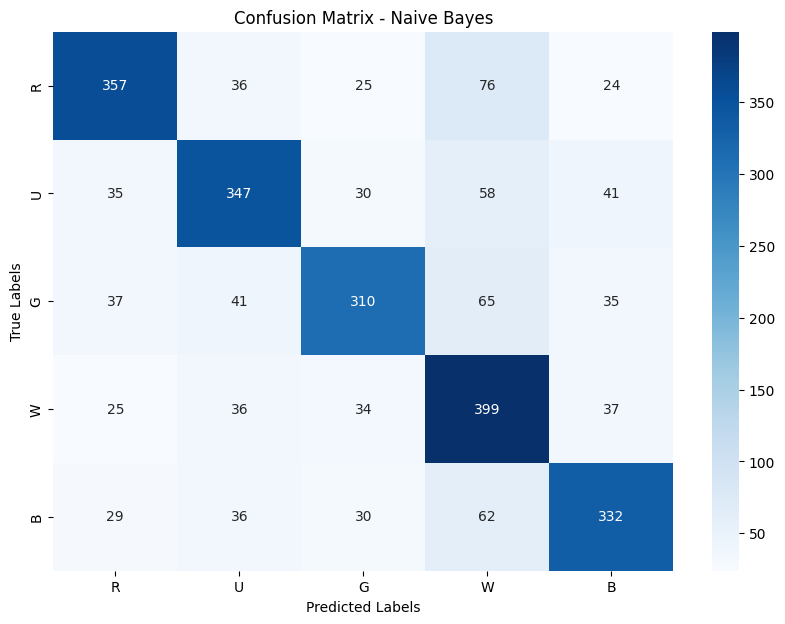

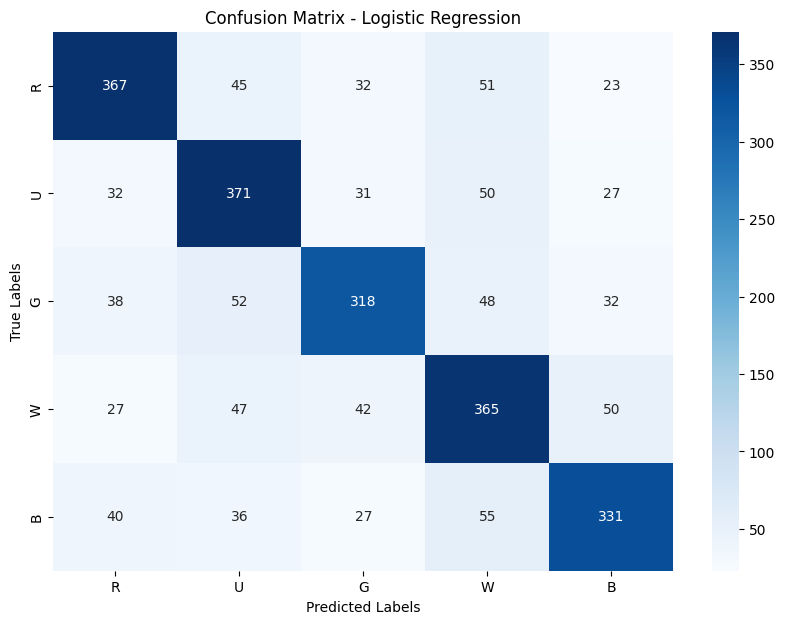

Model: TF-IDF + Naive Bayes
Accuracy: 0.69
Model: TF-IDF + Logistic Regression
Accuracy: 0.69

Naive Bayes metricas:
              precision    recall  f1-score   support

           R       0.71      0.68      0.69       489
           U       0.72      0.64      0.68       488
           G       0.74      0.69      0.71       518
           W       0.70      0.68      0.69       511
           B       0.60      0.75      0.67       531

    accuracy                           0.69      2537
   macro avg       0.69      0.69      0.69      2537
weighted avg       0.69      0.69      0.69      2537


Logistic metricas:
              precision    recall  f1-score   support

           R       0.71      0.68      0.70       489
           U       0.71      0.65      0.68       488
           G       0.73      0.71      0.72       518
           W       0.67      0.73      0.70       511
           B       0.64      0.69      0.66       531

    accuracy                           0.69     

In [41]:
train_texts = df_train["processed_flavor"].tolist() 
train_labels = df_train["color"].tolist() 

test_texts = df_test["processed_flavor"].tolist()  
test_labels = df_test["color"].tolist() 

#Vetorização dos textos com TF-IDF
vectorizer_text = CountVectorizer()
transformer_text = TfidfTransformer()

x_train_count = vectorizer_text.fit_transform(train_texts)
x_train_tfidf = transformer_text.fit_transform(x_train_count)

x_test_count = vectorizer_text.transform(test_texts)
x_test_tfidf = transformer_text.transform(x_test_count)

#print(x_train_tfidf)
#print('_____________')
#print(train_labels)
#print('_____________')
#print(x_test_tfidf)
#print('_____________')

#Naive Bayes e Regressão Logística
y_test_predict_nb = tune_NaiveBayesian(x_train_tfidf, train_labels, x_test_tfidf)
y_test_predict_lr = tune_Logistic(x_train_tfidf, train_labels, x_test_tfidf)

y_test_predict_nb = y_test_predict_nb.predict(x_test_tfidf)
y_test_predict_lr = y_test_predict_lr.predict(x_test_tfidf)

target_names = ["R", "U", "G", "W", "B"]  

#Calcular a Confusion Matrix para Naive Bayes
cm_nb = confusion_matrix(test_labels, y_test_predict_nb, labels=target_names)
#Calcular a Confusion Matrix para Regressão Logística
cm_lr = confusion_matrix(test_labels, y_test_predict_lr, labels=target_names)

#Confusion Matrix para Naive Bayes
plt.figure(figsize=(10, 7))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#Confusion Matrix para Regressão Logística
plt.figure(figsize=(10, 7))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#Métricas de classificação para Naive Bayes e Regressão Logística
metrics_bow_nb = collect_classification_metrics(test_labels, y_test_predict_nb, model_name="TF-IDF + Naive Bayes", target_names=target_names)
report_nb = evaluation(y_test_predict_nb, test_labels, target_names=target_names)

metrics_bow_lr = collect_classification_metrics(test_labels, y_test_predict_lr, model_name="TF-IDF + Logistic Regression", target_names=target_names)
report_lr = evaluation(y_test_predict_lr, test_labels, target_names=target_names)

print("\nNaive Bayes metricas:")
print(report_nb)

print("\nLogistic metricas:")
print(report_lr)

## Análise de Textos Classificados Incorretamente e Corretamente

Após as previsões, tivemos a ideia de identificar e analisar os textos que foram classificados incorretamente e corretamente pelos modelos de forma que nos possa permitir compreender melhor onde os modelos cometem erros fazendo comparações entre as palavras de cada cor (certas e erradas) de forma a melhorar o desempenho do nosso modelo através de ajustes ou melhorias nos dados (remover palavras por exemplo).

### Organizar os textos por classificados corretamente e incorretamente

Criamos a função **organize_texts_by_classification** com o objetivo de comparar os dados previstos com os dados reais de forma a separar posteriormente em dois: Os que foram bem previstos, e os que nao foram bem previstos

### World Clouds e Graficos de barras

#### World Clouds

Geramos World Cloudss separadas para as palavras dos textos classificados corretamente e incorretamente. O que nos permitio identificar as palavras que mais frequentemente aparecem em cada cor em termos de quantidade. 

#### Gráficos de Barras

Para uma melhor vizualização de frequecia e posterior facilidade na comparação, decidimos tambem utilizar gráficos de barras para representar a frequência das palavras mais comuns em cada cor.


In [42]:
def organize_texts_by_classification(test_texts, test_labels, predicted_labels):
    correct_by_color = defaultdict(list)
    incorrect_by_color = defaultdict(list)
    for text, true_label, pred_label in zip(test_texts, test_labels, predicted_labels):
        if true_label == pred_label:  # Classificação correta
            correct_by_color[true_label].append(text)
        else:  # Classificação incorreta
            incorrect_by_color[true_label].append(text)
    return correct_by_color, incorrect_by_color

# Separar os textos corretamente e incorretamente classificados
correct_by_color_nb, incorrect_by_color_nb = organize_texts_by_classification(test_texts, test_labels, y_test_predict_nb)
correct_by_color_lr, incorrect_by_color_lr = organize_texts_by_classification(test_texts, test_labels, y_test_predict_lr)


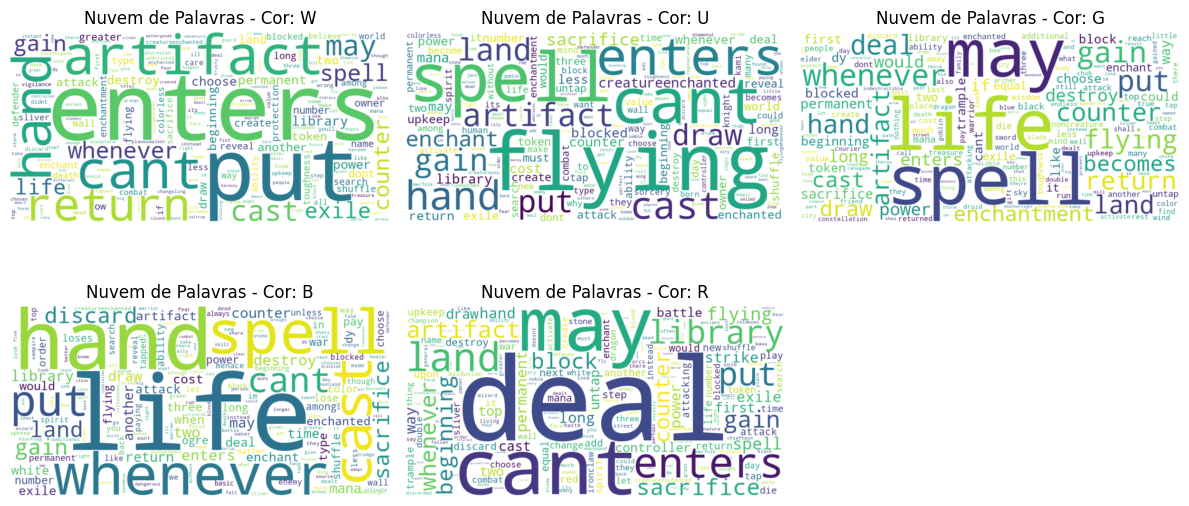

In [43]:
wordcloud_by_color = {}

for color, texts in incorrect_by_color_nb.items():
    text_combined = ' '.join(texts)
    word_counts = vectorizer.fit_transform([text_combined]) 
    word_freq = pd.DataFrame(word_counts.toarray(), columns=vectorizer.get_feature_names_out())
    wordcloud_by_color[color] = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq.sum(axis=0))


plt.figure(figsize=(12, 6))

for i, (color, wordcloud) in enumerate(wordcloud_by_color.items(), 1):
    plt.subplot(2, 3, i)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f'Nuvem de Palavras - Cor: {color}')

plt.tight_layout()
plt.show()


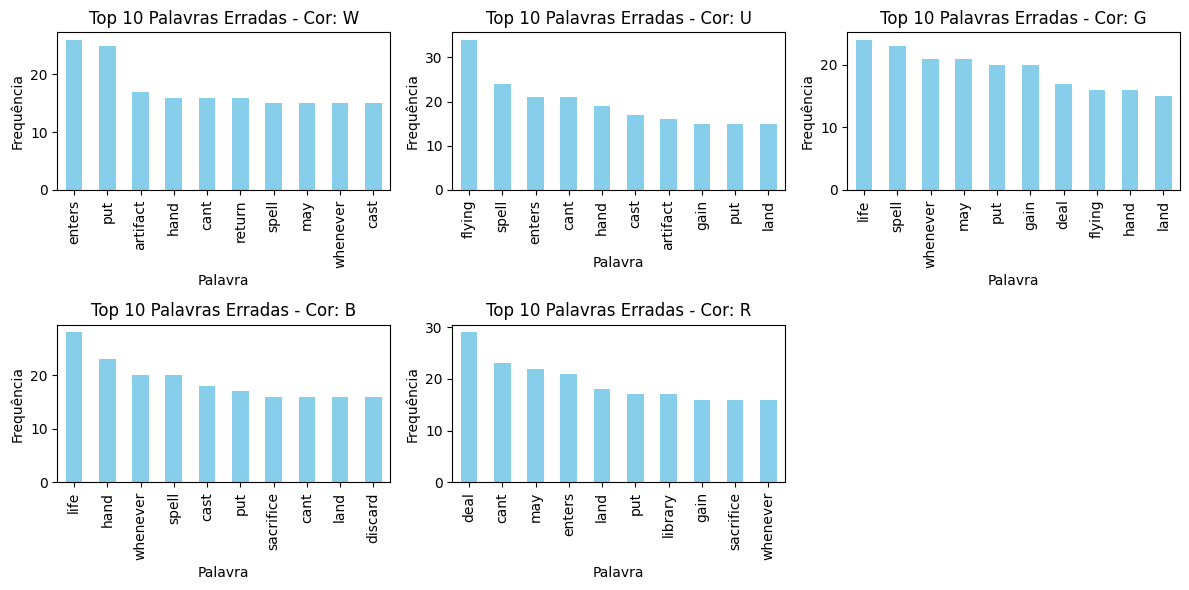

In [44]:
plt.figure(figsize=(12, 6))

for i, (color, texts) in enumerate(incorrect_by_color_nb.items(), 1):
    text_combined = ' '.join(texts)
    word_counts = vectorizer.fit_transform([text_combined])
    word_freq = pd.DataFrame(word_counts.toarray(), columns=vectorizer.get_feature_names_out())
    word_freq_sorted = word_freq.sum(axis=0).sort_values(ascending=False).head(10)
    
    plt.subplot(2, 3, i)
    word_freq_sorted.plot(kind="bar", color="skyblue")
    plt.title(f'Top 10 Palavras Erradas - Cor: {color}')
    plt.xlabel("Palavra")
    plt.ylabel("Frequência")

plt.tight_layout()
plt.show()


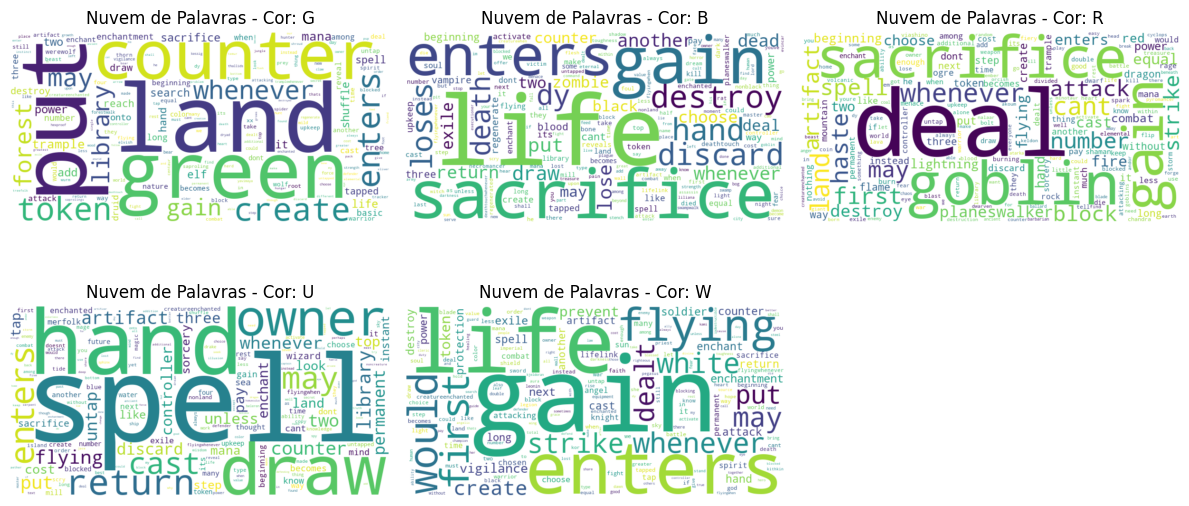

In [45]:

wordcloud_by_color = {}

for color, texts in correct_by_color_nb.items():
    text_combined = " ".join(texts) 
    word_counts = vectorizer.fit_transform([text_combined]) 
    word_freq = pd.DataFrame(word_counts.toarray(), columns=vectorizer.get_feature_names_out())
    wordcloud_by_color[color] = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq.sum(axis=0))

plt.figure(figsize=(12, 6))

for i, (color, wordcloud) in enumerate(wordcloud_by_color.items(), 1):
    plt.subplot(2, 3, i)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f'Nuvem de Palavras - Cor: {color}')

plt.tight_layout()
plt.show()


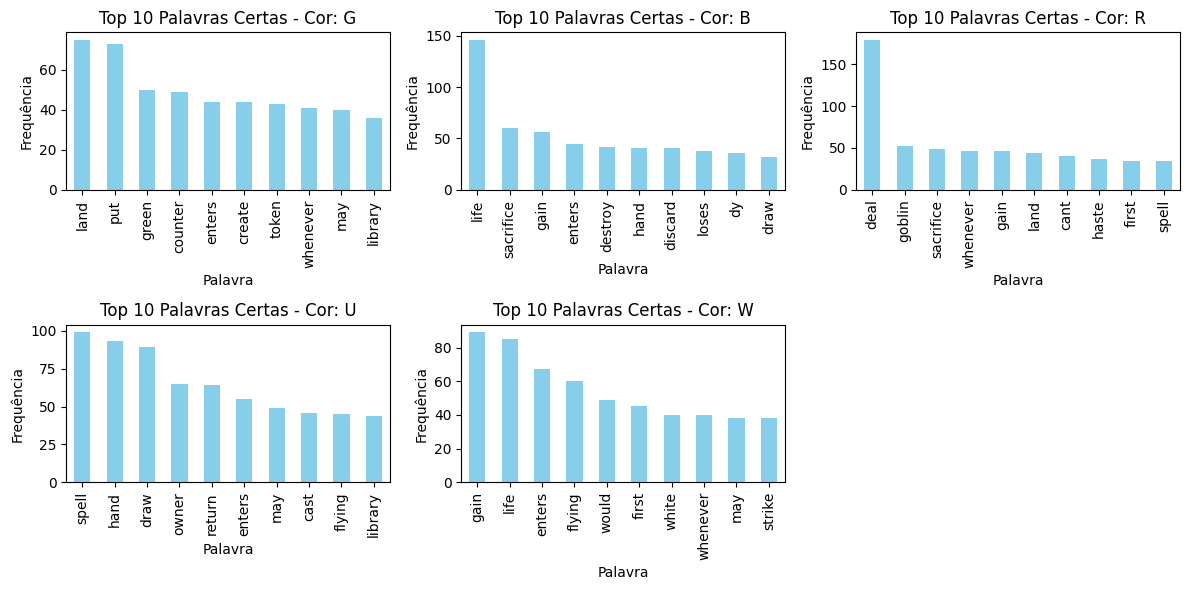

In [46]:
plt.figure(figsize=(12, 6))

for i, (color, texts) in enumerate(correct_by_color_nb.items(), 1):
    text_combined = " ".join(texts)
    word_counts = vectorizer.fit_transform([text_combined])
    word_freq = pd.DataFrame(word_counts.toarray(), columns=vectorizer.get_feature_names_out())
    word_freq_sorted = word_freq.sum(axis=0).sort_values(ascending=False).head(10)
    
    plt.subplot(2, 3, i)
    word_freq_sorted.plot(kind="bar", color="skyblue")
    plt.title(f'Top 10 Palavras Certas - Cor: {color}')
    plt.xlabel("Palavra")
    plt.ylabel("Frequência")

plt.tight_layout()
plt.show()


# REDE NEURONAL

## Previsão das cores utilizando uma Rede Neuronal

Por fim, para aumentar a precisão do nosso modelo, decidimos implementar uma Rede Neuronal (MLP - Multi-Layer Perceptron). O objetivo foi explorar a capacidade de aprendizagem avançada da rede para capturar padrões complexos entre as frases associadas a cada cor.

A rede implementada utilizou múltiplas camadas ocultas para melhorar a representação dos dados. No entanto, devido ao tempo necessário para ajustar os hiperparâmetros e ao impacto limitado observado nos resultados finais, optámos por usar configurações padrão para a rede e focar a análise no desempenho geral.

### Problema da Rede Neuronal
Embora a Rede Neuronal tenha conseguido capturar padrões mais complexos nos dados, aproximando os valores de precisão (accuracy) entre as diferentes cores — ao contrário dos outros algoritmos, cujos resultados mostraram maior dispersão — a precisão geral acabou por diminuir. Assim, apesar de ser uma abordagem mais robusta, optámos por manter os modelos LR e NB como principais, devido ao menor custo computacional e aos resultados satisfatórios obtidos.



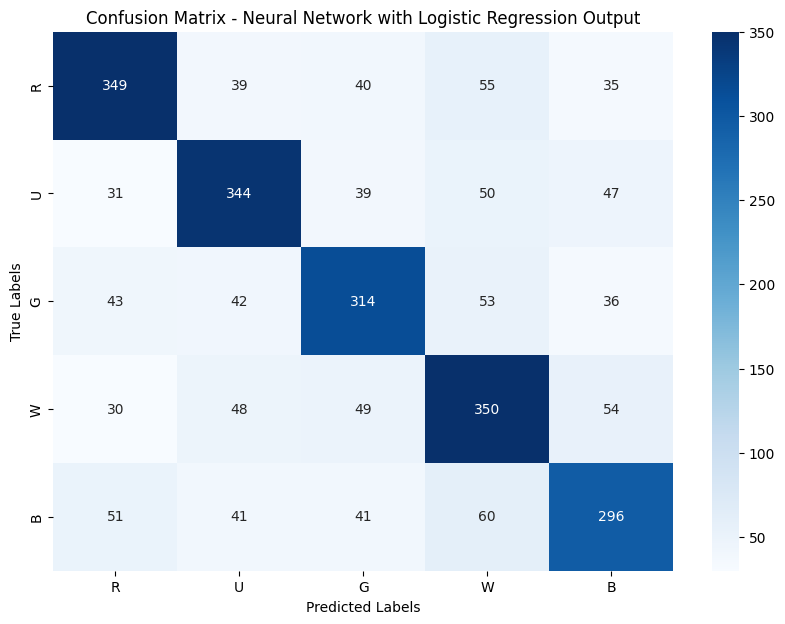


Neural Network métricas:
              precision    recall  f1-score   support

           R       0.63      0.61      0.62       489
           U       0.65      0.64      0.65       488
           G       0.69      0.67      0.68       518
           W       0.67      0.67      0.67       511
           B       0.62      0.66      0.64       531

    accuracy                           0.65      2537
   macro avg       0.65      0.65      0.65      2537
weighted avg       0.65      0.65      0.65      2537



In [47]:
#Rede Neuronal (MLP) p.s nao fizemos otimização de hiperparametros por culpa do tempo que demoravam, e tendo em conta que nao melhorava tanto o modelo, 
#decidimos dar a rede neuronal como exemplo e manter o modelo principal no LR e NB

mlp_model = MLPClassifier(hidden_layer_sizes=(25), max_iter=100, random_state=42)
mlp_model.fit(x_train_tfidf, train_labels)
y_test_predict_mlp = mlp_model.predict(x_test_tfidf)
cm_mlp = confusion_matrix(test_labels, y_test_predict_mlp, labels=target_names)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Neural Network with Logistic Regression Output")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print("\nNeural Network métricas:")
print(classification_report(test_labels, y_test_predict_mlp, target_names=target_names))


# PREVISOES COM FEATURES

## Previsão das cores utilizando features do dataframe inicial a partir do regex

Para acabar a nossa jornada de previsão das cores de cartas do jogo Magic: The Gathering, decidimos fazer um estudo utilizandos as colunas criadas inicialmente a partir do regex. Estas colunas representam palavras importantes que existiam dentro das frases.



In [48]:
df_prever = df.copy()

In [49]:
df_prever.columns

Index(['Unnamed: 0', 'name', 'multiverse_id', 'text', 'flavor', 'power',
       'color', 'counterspell', 'exile', 'fight', 'mill', 'scry', 'tap',
       'untap', 'double_strike', 'first_strike', 'flash', 'flying', 'haste',
       'hexproof', 'indestructible', 'sacrifice', 'life', 'gain', 'lifelink',
       'menace', 'protection', 'prowess', 'spell', 'reach', 'trample',
       'vigilance', 'draw', 'discard', 'deal', 'land', 'damage',
       'damage_prevention', 'life_gain', 'life_loss', 'tokens', 'destroy',
       'return', 'recursion', 'all_Text', 'processed_flavor'],
      dtype='object')

In [50]:
df_prever = df_prever.drop(columns=["Unnamed: 0", "multiverse_id","text","flavor","processed_flavor","name","all_Text"])

In [51]:
df_prever.isnull().sum()

power                5310
color                   0
counterspell            0
exile                   0
fight                 289
mill                  289
scry                  289
tap                   289
untap                 289
double_strike         289
first_strike          289
flash                   0
flying                289
haste                 289
hexproof              289
indestructible          0
sacrifice             289
life                  289
gain                  289
lifelink              289
menace                289
protection            289
prowess               289
spell                 289
reach                   0
trample               289
vigilance             289
draw                  289
discard               289
deal                  289
land                  289
damage                289
damage_prevention     289
life_gain             289
life_loss               0
tokens                289
destroy                 0
return                  0
recursion   

In [52]:
df_prever = df_prever.dropna() 

In [53]:
boolean_columns = ["counterspell", "exile", "fight", "mill", "scry", "tap", "untap", 
                   "double_strike", "first_strike", "flash", "flying", "haste", "hexproof", 
                   "indestructible", "sacrifice", "lifelink", "menace", "protection", "prowess", 
                   "reach", "trample", "vigilance", "draw", "discard", "damage", "damage_prevention", 
                   "life_gain", "life_loss", "tokens", "destroy", "return", "recursion","spell","gain",
                   "life","deal","land"]

#booleanas para inteiros (0 ou 1)
df_prever[boolean_columns] = df_prever[boolean_columns].astype(int)
#cores para números
color_mapping = {
    "G": 1,  # Verde
    "R": 2,  # Vermelho
    "U": 3,  # Azul
    "W": 4,  # Branco
    "B": 5   # Preto
}
df_prever["color"] = df_prever["color"].map(color_mapping)
df_prever = df_prever.drop("power", axis=1)
print(df_prever.head())

   color  counterspell  exile  fight  mill  scry  tap  untap  double_strike  \
0      4             0      0      0     0     0    0      0              0   
1      4             0      0      0     0     0    0      0              0   
4      4             0      0      0     0     0    0      0              0   
6      4             0      0      0     0     0    0      0              0   
7      4             0      0      0     0     0    0      0              0   

   first_strike  ...  deal  land  damage  damage_prevention  life_gain  \
0             1  ...     1     0       0                  0          1   
1             0  ...     0     0       0                  0          1   
4             0  ...     0     0       0                  0          0   
6             0  ...     0     0       0                  0          0   
7             0  ...     1     0       0                  0          0   

   life_loss  tokens  destroy  return  recursion  
0          0       0        0

In [54]:
df_prever.columns

Index(['color', 'counterspell', 'exile', 'fight', 'mill', 'scry', 'tap',
       'untap', 'double_strike', 'first_strike', 'flash', 'flying', 'haste',
       'hexproof', 'indestructible', 'sacrifice', 'life', 'gain', 'lifelink',
       'menace', 'protection', 'prowess', 'spell', 'reach', 'trample',
       'vigilance', 'draw', 'discard', 'deal', 'land', 'damage',
       'damage_prevention', 'life_gain', 'life_loss', 'tokens', 'destroy',
       'return', 'recursion'],
      dtype='object')

In [55]:
print(df_prever.dtypes)

color                int64
counterspell         int32
exile                int32
fight                int32
mill                 int32
scry                 int32
tap                  int32
untap                int32
double_strike        int32
first_strike         int32
flash                int32
flying               int32
haste                int32
hexproof             int32
indestructible       int32
sacrifice            int32
life                 int32
gain                 int32
lifelink             int32
menace               int32
protection           int32
prowess              int32
spell                int32
reach                int32
trample              int32
vigilance            int32
draw                 int32
discard              int32
deal                 int32
land                 int32
damage               int32
damage_prevention    int32
life_gain            int32
life_loss            int32
tokens               int32
destroy              int32
return               int32
r

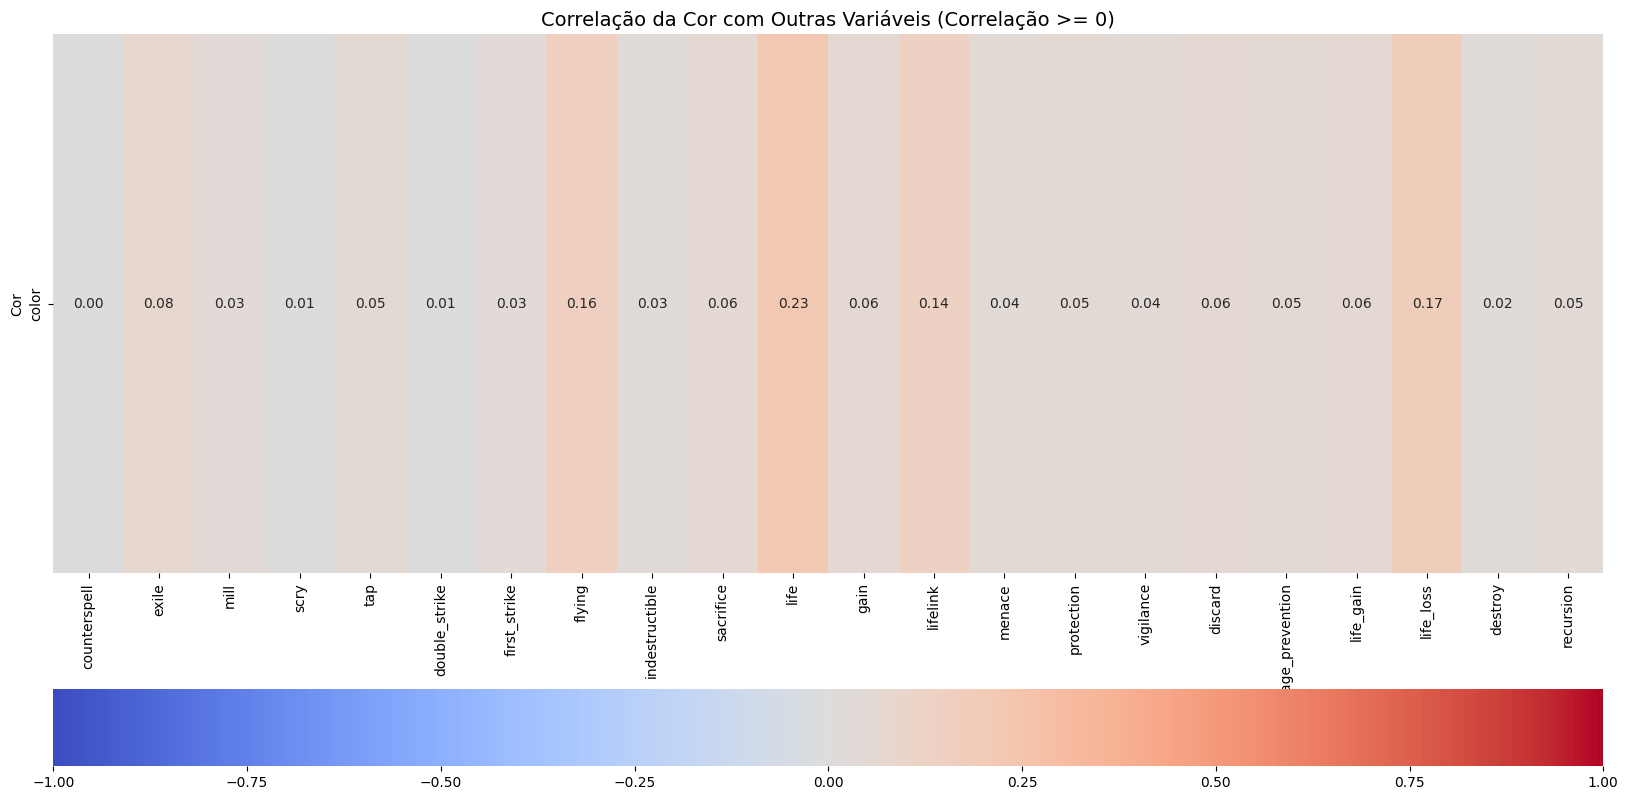

In [56]:
df_selected = df_prever.copy()

correlation_matrix = df_selected.corr()
color_correlation = correlation_matrix.loc[['color'], correlation_matrix.columns != 'color']
positive_correlation_columns = color_correlation.columns[color_correlation.iloc[0] >= 0]
df_selected = df_selected[positive_correlation_columns]

plt.figure(figsize=(20, 10)) 
sns.heatmap(color_correlation[positive_correlation_columns], annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1, cbar_kws={"orientation": "horizontal"})
plt.title("Correlação da Cor com Outras Variáveis (Correlação >= 0)", fontsize=14)
plt.xlabel("Variáveis")
plt.ylabel("Cor")
plt.show()

#colunas com correlação >= 0

In [57]:
X = df_selected  
y = df_prever["color"]  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [58]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [59]:
y_pred = model.predict(X_test)
print("Acc:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Acc: 0.4050811573747354
              precision    recall  f1-score   support

           1       0.33      0.68      0.45       314
           2       0.35      0.17      0.22       277
           3       0.45      0.41      0.43       256
           4       0.52      0.38      0.44       298
           5       0.51      0.35      0.42       272

    accuracy                           0.41      1417
   macro avg       0.43      0.40      0.39      1417
weighted avg       0.43      0.41      0.39      1417



# WORLD CLOUD

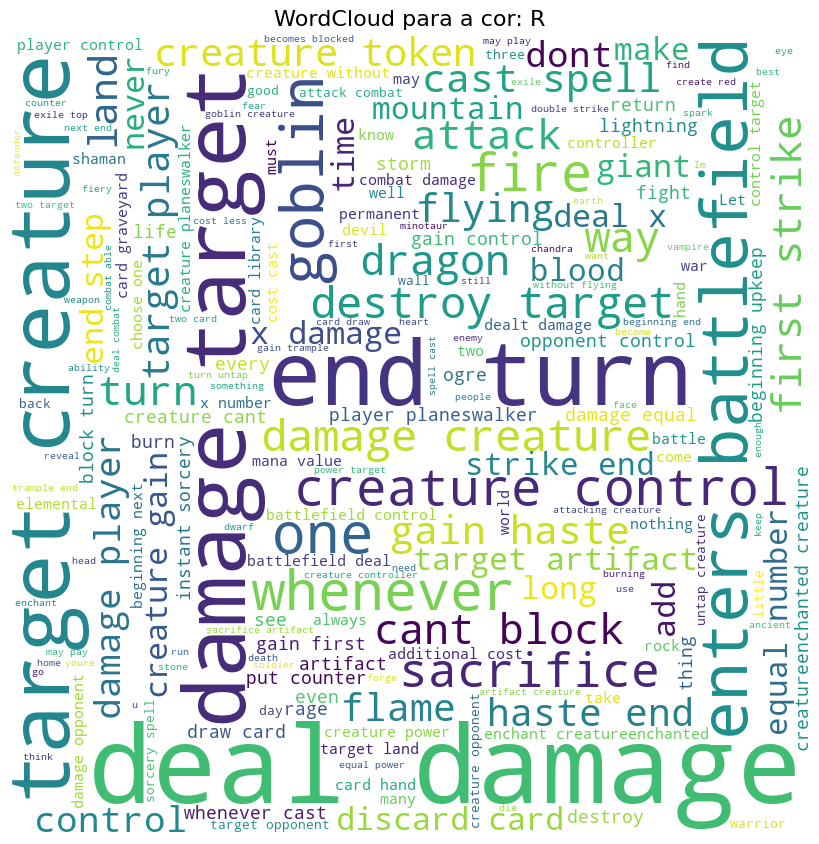

In [60]:
#Função para gerar o WordCloud para uma cor específica
def gerar_wordcloud_cor(cor, df):
    filtered_words = df[df["color"].str.contains(cor, case=False, na=False)]["processed_flavor"]
    comment_words = " ".join(filtered_words)

    if comment_words:
        wordcloud = WordCloud(width=800, height=800,
                              background_color="white",
                              stopwords=STOPWORDS,
                              min_font_size=10).generate(comment_words)

        plt.figure(figsize=(8, 8), facecolor=None)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.tight_layout(pad=0)
        plt.title(f"WordCloud para a cor: {cor}", fontsize=16)
        plt.show()
    else:
        print(f"Não há palavras associadas à cor: {cor}")

cor_escolhida = "R"  # Exemplo: red, podemos substituir por qualquer cor
gerar_wordcloud_cor(cor_escolhida, df)


# Fazer Carregamento dos modelos no pickle

In [61]:
import pickle

# Treinar os modelos
naive_bayes_model = tune_NaiveBayesian(x_train_tfidf, train_labels, x_test_tfidf)
logistic_model = tune_Logistic(x_train_tfidf, train_labels, x_test_tfidf)

# Salvar o modelo do Naive Bayes
with open('naive_bayes_model.pkl', 'wb') as f:
    pickle.dump(naive_bayes_model, f)

# Salvar o modelo da Regressão Logística
with open('logistic_model.pkl', 'wb') as f:
    pickle.dump(logistic_model, f)

# Salvar o vectorizer
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer_text, f)

# Salvar o transformer
with open('transformer.pkl', 'wb') as f:
    pickle.dump(transformer_text, f)



Melhor parâmetro para Naive Bayes: {'alpha': 1.0}
Melhor parâmetro para Regressão Logística: {'C': 10, 'class_weight': 'balanced', 'max_iter': 50}
